In [1]:
import torch
from geomloss import SamplesLoss

/home/kapil/anaconda3/envs/cs137/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


IMSIZE= 100

X = np.zeros((100, 100))
Y = np.zeros((100, 100))
m1, cov1 = np.array([70.0, 70.0]), np.array([15.0, 4.0])
#m2, cov2 = np.array([30.0, 50.0]), np.array([5.0, 9.0])
m2, cov2 = np.array([30.0, 30.0]), np.array([3.0, 5.0])

def return_map(IMSIZE, mean, cov):
    X = np.zeros((IMSIZE, IMSIZE))
    for i in range(IMSIZE):
        for j in range(IMSIZE):
            z = (np.array([i, j]) - mean) / cov
            X[i, j] = norm.pdf(z[0]) * norm.pdf(z[1])
    return X

X = return_map(IMSIZE, m1, cov1)
Y = return_map(IMSIZE, m2, cov2)

X /= np.sum(X)
Y /= np.sum(Y)

X = np.where(X > 0.0009, 1, 0)
Y = np.where(Y > 0.0009, 1, 0)

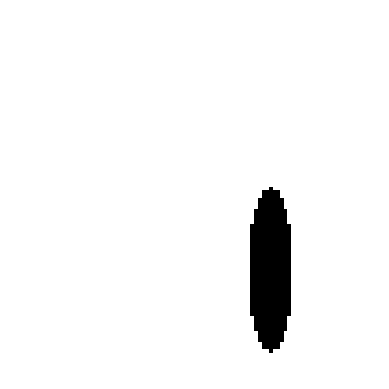

In [152]:
plt.axis("off")
plt.imshow(X, cmap = "Greys")
plt.savefig("gaussian1.png")

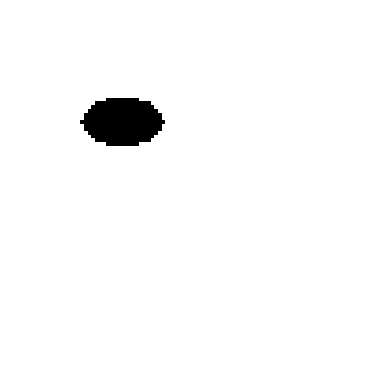

In [153]:
plt.axis("off")
plt.imshow(Y, cmap = "Greys")
plt.savefig("gaussian2.png")

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [302]:
from random import choices
from imageio import imread


def load_image(fname, **kwargs):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1, :]) / 255.0
    #plt.figure()
    height, width = img.shape
    img = img[height // 9: height - int(height / 20), width// 9: width - int(width / 20)]
    img = np.where(img > 0.25, 0, 1)
    #plt.imshow(img, cmap = "Greys")
    return 1 - img

load_image("cmap/r11_new_cmap_tt--2I26_Ox2I26_P_true.png")


def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)
    
    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[1]),
        np.linspace(0, 1, A.shape[0]),
        indexing="xy",
    )

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() 
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")

/tmp/ipykernel_49862/3912420727.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, as_gray=True)  # Grayscale


/tmp/ipykernel_49862/1706569780.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, as_gray=True)  # Grayscale


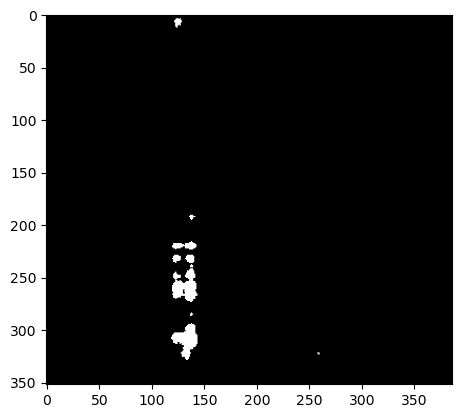

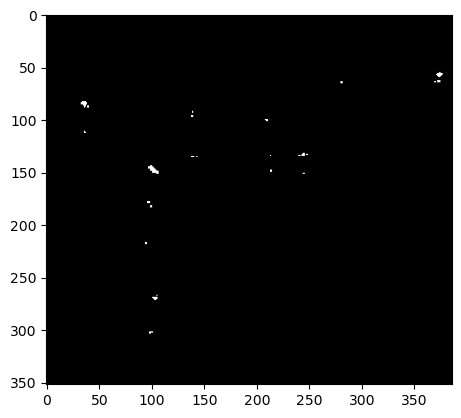

In [212]:
# N, M = (100, 100) # if not use_cuda else (10000, 10000
# X_i = draw_samples("density_a.png", N, dtype)
# Y_j = draw_samples("density_b.png", M, dtype)
N, M = 1000, 1000
X_i = draw_samples("cmap/r11_new_cmap_tt--4DIN_Ax4DIN_B_pred.png", N, dtype)
Y_j = draw_samples("cmap/r11_new_cmap_tt--4DIN_Ax4DIN_B_true.png", M, dtype)

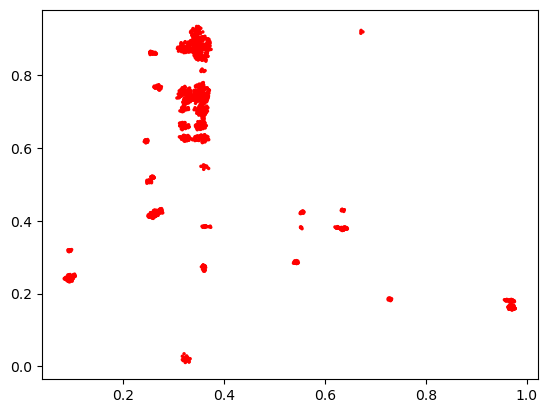

In [213]:
plt.figure()
ax = plt.subplot(111)
display_samples(ax, torch.cat([X_i, Y_j]), "red")

In [214]:
def gradient_descent(loss, lr=1):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = 21
    display_its = [0, 2, 10, 20]

    # Use colors to identify the particles
    colors = (20 * X_i[:, 0]).cos() * (20 * X_i[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    colors = np.concatenate([np.zeros(colors.shape), colors])
    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 12))
    k = 1
    optim = torch.optim.SGD([x_i], lr = lr/2 * len(x_i))
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        optim.zero_grad()
        L_αβ = loss(x_i, y_j)
        L_αβ.backward()
        
        # [g] = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            k = k + 1
            plt.set_cmap("hsv")
            plt.scatter(
                [-0.5, -0.5], [1, 1]
            )  # shameless hack to prevent a slight change of axis...

            #display_samples(ax, y_j, [(0.55, 0.55, 0.95)])
            display_samples(ax, torch.concat([y_j, x_i]) , colors)

            ax.set_title("it = {}".format(i))

            plt.axis([0, 1, 0, 1])
            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        optim.step()
        #x_i.data -= lr * len(x_i) * g
    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / Nsteps)
    )

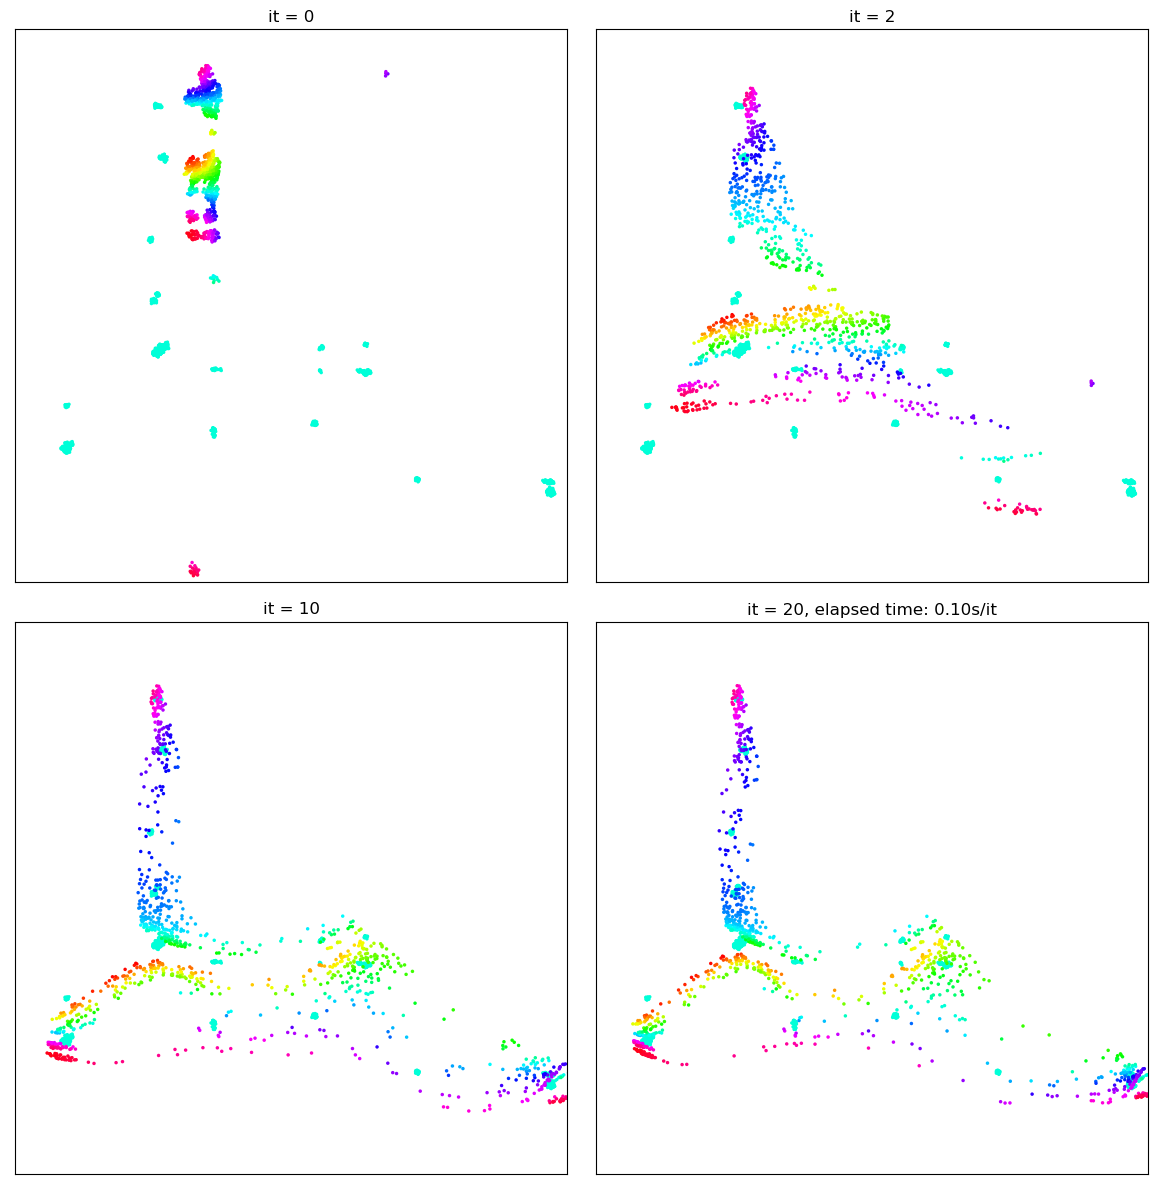

In [215]:
gradient_descent(SamplesLoss("sinkhorn", p=2, blur=0.1))

In [231]:
xv, yv = torch.meshgrid(
    torch.linspace(0, 1, 10),
    torch.linspace(0, 1, 10),
    indexing = "xy"
)
grid = torch.stack([xv.reshape(-1), yv.reshape(-1)], axis = 1)
A = torch.randn(100, requires_grad = True)
A = torch.where(A > 0.99, 1.0, 0.0)

B = torch.where(torch.randn(100) >  0.75, 1.0, 0.0)
B

tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])

In [233]:
target = torch.multinomial(B, 1000, replacement = True)
pred = torch.multinomial(A, 1000, replacement = True)

X_i = grid[target]
Y_i = grid[pred]

loss = SamplesLoss("sinkhorn", p=2, blur=0.1)

In [235]:
lval = loss(X_i, Y_i)
[g] = torch.autograd.grad(lval, [X_i])
g

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


/tmp/ipykernel_49862/1706569780.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, as_gray=True)  # Grayscale


tensor([[[0.4946, 0.4944],
         [0.4767, 0.4984],
         [0.5275, 0.5442],
         [0.4627, 0.4855],
         [0.5156, 0.4887],
         [0.4933, 0.4770],
         [0.5194, 0.5522],
         [0.4991, 0.5086],
         [0.4947, 0.5087],
         [0.5105, 0.5098],
         [0.4982, 0.4866],
         [0.4833, 0.5041],
         [0.5384, 0.5225],
         [0.4965, 0.4855],
         [0.4882, 0.5018],
         [0.4887, 0.4926],
         [0.5073, 0.5215],
         [0.5042, 0.5169],
         [0.5188, 0.4947],
         [0.5044, 0.4930],
         [0.4812, 0.4832],
         [0.5081, 0.5152],
         [0.4777, 0.4985],
         [0.5032, 0.4559],
         [0.5240, 0.5224],
         [0.5068, 0.4965],
         [0.5061, 0.5273],
         [0.5072, 0.5257],
         [0.4980, 0.5035],
         [0.5100, 0.5065],
         [0.5037, 0.5242],
         [0.5375, 0.5501],
         [0.4894, 0.5023],
         [0.5475, 0.5089],
         [0.5194, 0.5276],
         [0.5110, 0.5137],
         [0.5112, 0.5241],
 

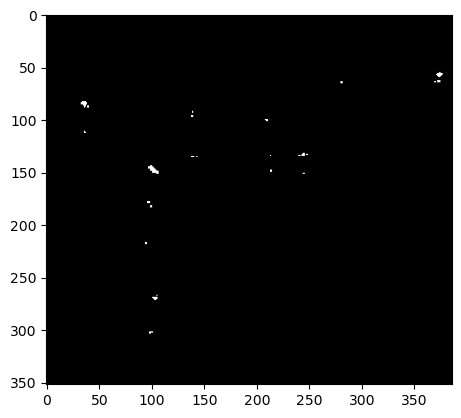

In [301]:
import torch.nn as nn
import torch.nn.functional as F


class SamplingModel(nn.Module): 
    def __init__(self):
        super(SamplingModel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 2, stride = 2), # N, 1, H, W => N, 5, H', W'
            nn.Tanh(),
            nn.MaxPool2d(3),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels = 5, out_channels = 2, kernel_size = 7, stride = 2), # N, 5, H'', W'' => N, 2, H''', W'''
            nn.MaxPool2d(2),
            nn.Tanh(),
            nn.Flatten(start_dim = 2),
            nn.LazyLinear(100),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)
A = load_image("cmap/r11_new_cmap_tt--4DIN_Ax4DIN_B_true.png")
A = torch.tensor(A, dtype = torch.float32).unsqueeze(0).unsqueeze(0)
print(A)
model = SamplingModel()
torch.transpose(model(A), 1, 2)

#"cmap/r11_new_cmap_tt--4DIN_Ax4DIN_B_pred.png"

In [324]:
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob
class CmapData(Dataset):
    def __init__(self, folder, no_samples = 100, max_row = 500, max_col = 500):
        super(CmapData, self).__init__()
        self.files = glob(f"{folder}/*")
        self.no_samples = no_samples
        self.max_row = max_row
        self.max_col = max_col
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, id):
        file = self.files[id]
        A = load_image(file)
        m, n = A.shape
        
        assert m < self.max_row and n < self.max_col
        pad_y = self.max_row - m
        pad_x = self.max_col - n
        
        A = np.pad(A, ((0, pad_y), (0, pad_x)))

        A = torch.tensor(A, dtype = torch.float32).unsqueeze(0)
        X = draw_samples(file, self.no_samples, dtype = torch.float32)
        return A, X
allset = CmapData("cmap", 100)
n = len(allset)
trainset, testset = random_split(allset, [int(0.9 * n) , n - int(0.9 * n)])
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)
len(testset)

5

In [329]:
A = load_image("cmap/r11_new_cmap_tt--4DIN_Ax4DIN_B_true.png")
A = torch.tensor(A, dtype = torch.float32).unsqueeze(0).unsqueeze(0)
Y_j = draw_samples("cmap/r11_new_cmap_tt--4DIN_Ax4DIN_B_true.png", 100, dtype)

model = SamplingModel()
model.train()

lossf = SamplesLoss("sinkhorn", p=2, blur=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
plt.figure(figsize=(12, 12))
k = 1
display_its = [1, 100, 250, 1000]
for i in range(100):
    running_loss = 0
    for e, data in enumerate(trainloader):
        A, Y = data
        optimizer.zero_grad()
        Y_pred = torch.transpose(model(A), 1, 2).squeeze(0).squeeze(0)
        loss = lossf(Y.squeeze(0), Y_pred)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= (e+1)
    print(f"Running Iteration {i+1}, Loss: {running_loss}")

/tmp/ipykernel_49862/3912420727.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, as_gray=True)  # Grayscale


Running Iteration 1, Loss: 0.08924673781616659
Running Iteration 2, Loss: 0.09452771181922133
Running Iteration 3, Loss: 0.0886952123127696
Running Iteration 4, Loss: 0.08226464620632369
Running Iteration 5, Loss: 0.0829278597403772
Running Iteration 6, Loss: 0.07817857644361693
Running Iteration 7, Loss: 0.07154076008080709
Running Iteration 8, Loss: 0.07091856934130192
Running Iteration 9, Loss: 0.06480639743641382
Running Iteration 10, Loss: 0.06364789473392614
Running Iteration 11, Loss: 0.0635311528358881
Running Iteration 12, Loss: 0.05945118539398763
Running Iteration 13, Loss: 0.06124399700088472
Running Iteration 14, Loss: 0.05713713395113989
Running Iteration 15, Loss: 0.058801767779741346
Running Iteration 16, Loss: 0.05703728033865734
Running Iteration 17, Loss: 0.0560874281814549
Running Iteration 18, Loss: 0.056948974569577995
Running Iteration 19, Loss: 0.05496535797762435
Running Iteration 20, Loss: 0.055016966593429084
Running Iteration 21, Loss: 0.05241529850243795
Ru

<Figure size 1200x1200 with 0 Axes>

/tmp/ipykernel_49862/3912420727.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, as_gray=True)  # Grayscale


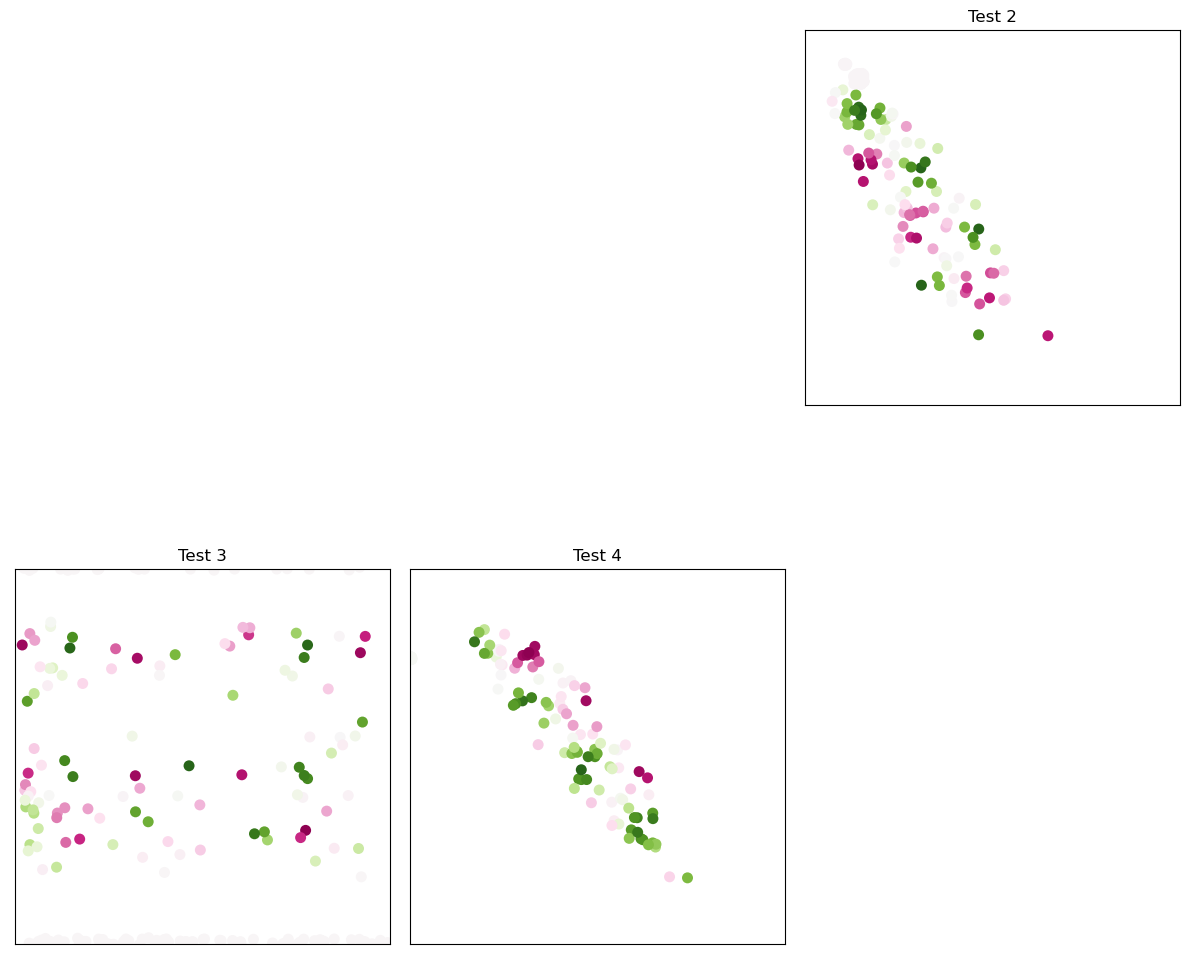

In [346]:
model.eval()
plt.figure(figsize = (12, 12))
with torch.no_grad():
    for k in range(5):
        A, Y = testset[k]
        Ypred = torch.transpose(model(A.unsqueeze(0)), 1, 2).squeeze(0).squeeze(0)
        colors = (20 * Ypred[:, 0]).cos() * (20 * Ypred[:, 1]).cos()
        ax = plt.subplot(2, 3, k+1)
        colors = colors.numpy()
        colors = np.concatenate([colors, 
                                 [0] * colors.shape[0]
                                ])
        plt.set_cmap("PiYG")
        plt.scatter([-0.5, -0.5], [1, 1])
        display_samples(ax, torch.concat([Ypred, 
                                          Y
                                         ]), colors)
        ax.set_title(f"Test {k}")
        plt.axis([0, 1, 0, 1])
        plt.gca().set_aspect("equal", adjustable="box")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.tight_layout()

/tmp/ipykernel_49862/3912420727.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, as_gray=True)  # Grayscale


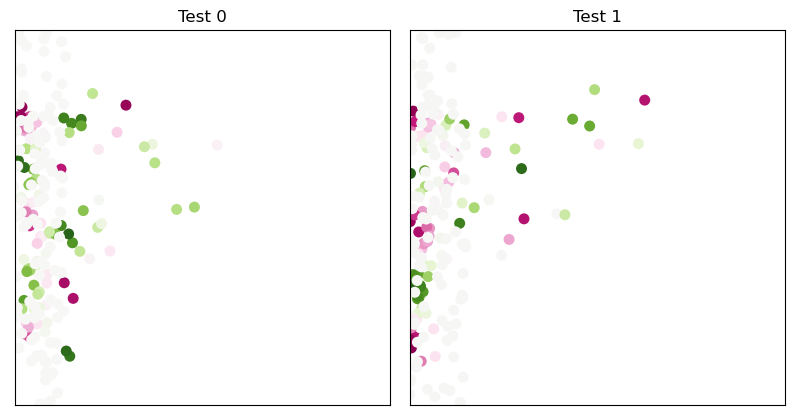

In [347]:
model.eval()
plt.figure(figsize = (12, 12))
with torch.no_grad():
    for k in range(2):
        A, Y = testset[k]
        Ypred = torch.transpose(model(A.unsqueeze(0)), 1, 2).squeeze(0).squeeze(0)
        colors = (20 * Ypred[:, 0]).cos() * (20 * Ypred[:, 1]).cos()
        ax = plt.subplot(2, 3, k+1)
        colors = colors.numpy()
        colors = np.concatenate([colors, 
                                 [0] * colors.shape[0]
                                ])
        plt.set_cmap("PiYG")
        plt.scatter([-0.5, -0.5], [1, 1])
        display_samples(ax, torch.concat([Ypred, 
                                          Y
                                         ]), colors)
        ax.set_title(f"Test {k}")
        plt.axis([0, 1, 0, 1])
        plt.gca().set_aspect("equal", adjustable="box")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.tight_layout()